In [17]:
import matplotlib.pyplot as plt
from stompy.grid import unstructured_grid 
from stompy import utils
import xarray as xr
import os, glob
import numpy as np
%matplotlib notebook

In [21]:
hourly_ncs=glob.glob('hourly-out-v03/surface*.nc')
hourly_ncs.sort()
len(hourly_ncs)

7728

In [3]:
# Experiment level configuration -- small, all python native data.
# The 'new' run
cfg=dict(
    ptm_base_dir="/opt2/sfb_ocean/ptm/all_source_022b",
    sun_base_dir="/opt2/sfb_ocean/suntans/runs",
    ptm_output_interval=np.timedelta64(1,'h')
)
cfg['ptm_run_patt']=os.path.join(cfg['ptm_base_dir'],"chunk??","20??????")
cfg['sun_patt']=os.path.join(cfg['sun_base_dir'],"merged_022_20??????")

ptm_run_paths=glob.glob(cfg['ptm_run_patt'])
ptm_run_paths.sort()
cfg['ptm_run_paths']=ptm_run_paths

sun_paths=glob.glob(cfg['sun_patt'])
sun_paths.sort()
cfg['sun_paths']=sun_paths
hydro_path=sun_paths[0]
ptm_ds=xr.open_dataset(os.path.join(hydro_path,"ptm_average.nc_0000.nc"))
grid=unstructured_grid.UnstructuredGrid.read_ugrid(ptm_ds,dialect='fishptm')
grid_poly=grid.boundary_polygon()

INFO:join_features:0 open strings, 25 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=38109911619.298943, 24 potential interiors


In [4]:
Msmooth=grid.smooth_matrix()
Msmooth_K=grid.smooth_matrix(K=100*np.ones(grid.Nedges()))

INFO:utils:57601/99089
INFO:utils:55135/99089


In [5]:
import postproc_dask as post

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [6]:
def filter_stream(fns,win,stride=24):
    N=len(win)
    # Load the first set:
    idx=0 # index of the next unread step
    dss=[]

    while 1:
        # Load enough to get to N:
        while len(dss)<N:
            if idx>=len(fns):
                return
            dss.append(xr.open_dataset(fns[idx]))
            idx+=1
        
        # Calculate the average:
        out=np.zeros(dss[0].dims['cell'],np.float64)

        for weight,ds in zip(win,dss):
            out += ds.conc.values * weight
        ds_out=dss[0].copy()
        ds_out['conc']=('cell',),out
        ds_out['time']=(),dss[N//2].time.values
        ds_out['time_min']=(),dss[0].time.values
        ds_out['time_max']=(),dss[-1].time.values
        yield ds_out
        
        stale=dss[:stride]
        for ds in stale:
            ds.close()
        dss=dss[stride:]
        if stride>N:
            idx+=(stride-N)


In [7]:
import conc_figure
from matplotlib import cm
import stompy.plot.cmap as scmap
#cmap=cm.CMRmap_r
#cmap=scmap.cmap_clip(cmap,0.08,1)
cmap='inferno_r'

<IPython.core.display.Javascript object>


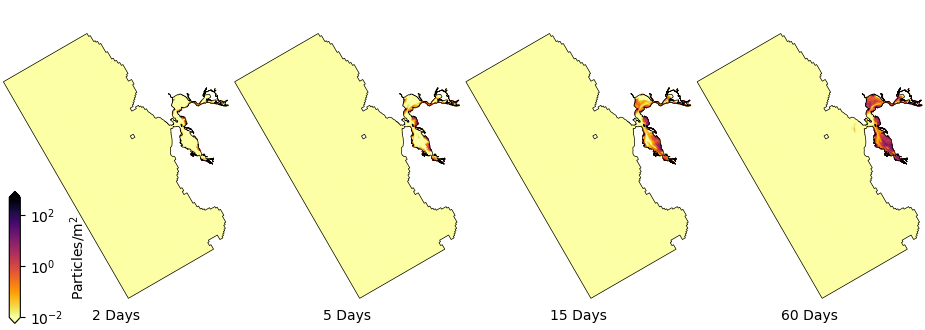

<IPython.core.display.Javascript object>


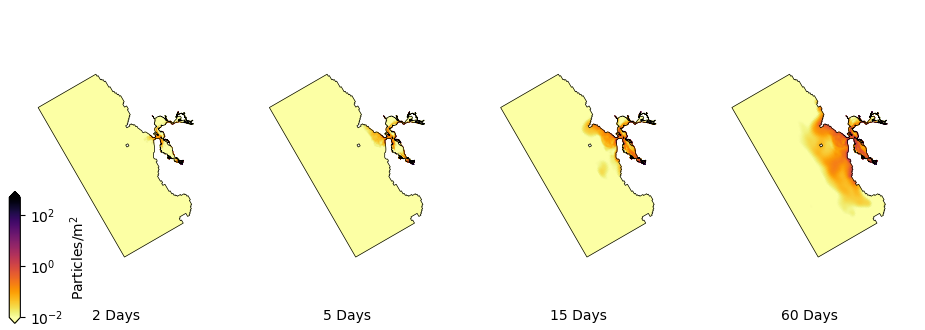

<IPython.core.display.Javascript object>


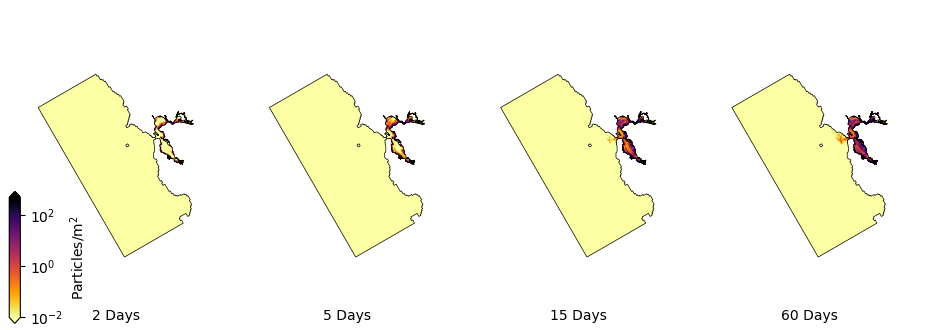

<IPython.core.display.Javascript object>


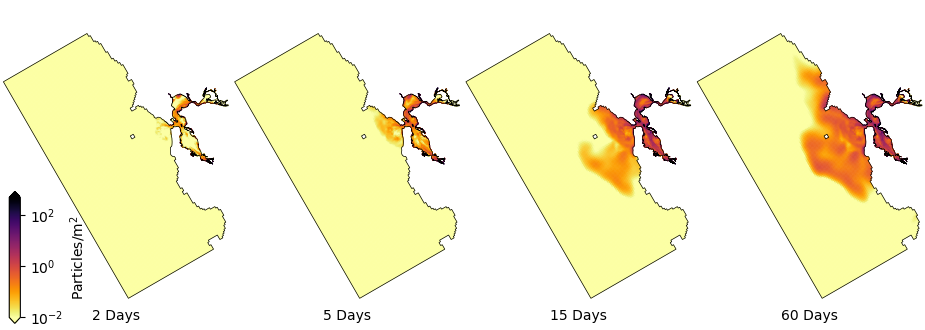

<IPython.core.display.Javascript object>


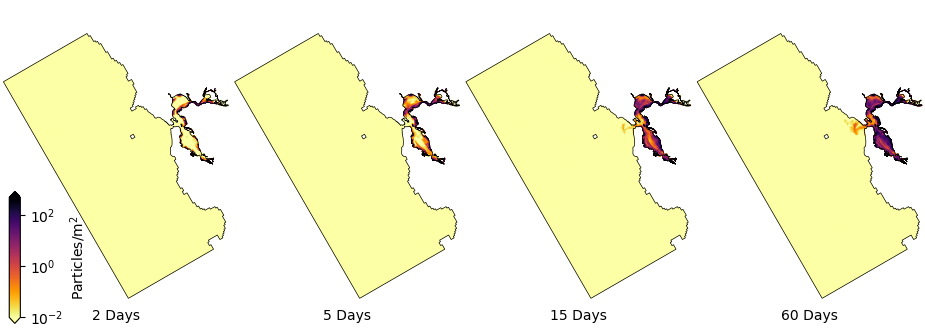

<IPython.core.display.Javascript object>


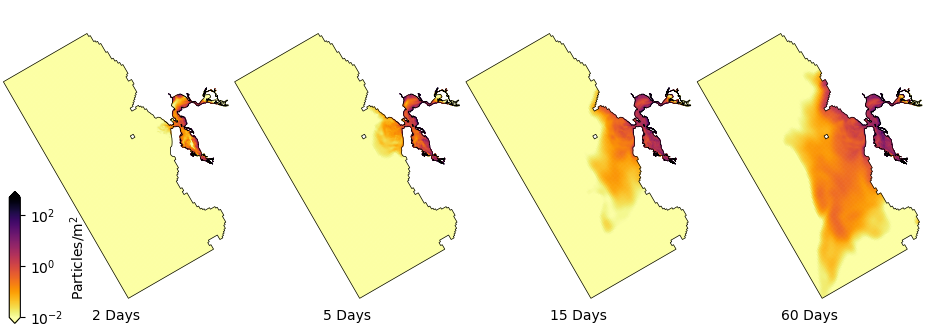

In [8]:
# Show reach of particles over time:
out_dir="snapshots-v02"

conc_fns=glob.glob(os.path.join(out_dir,'*.nc'))
conc_fns.sort()

for conc_fn in conc_fns:
    fig_fn=conc_fn.replace('.nc','.png')
    #if os.path.exists(fig_fn): continue
    
    ds=xr.open_dataset(conc_fn)

    ages=[2,5,15,60]

    fig,axs=plt.subplots(1,len(ages),figsize=(9.25,3.3))
    fig.subplots_adjust(left=0,right=1,top=1,bottom=0,wspace=0)
    fig.canvas.draw()

    kws=dict(fig=fig,grid=grid,grid_poly=grid_poly,cmap=cmap,
             #vmin=1e-2,vmax=500,
             cax_loc=[0.05,0.05,0.04,0.45])

    plots=[]
    for ax,age_max in zip(axs,ages):
        ds_sel=ds.sel(age_max=age_max).copy()
        # Smooth some...
        conc=ds_sel['conc'].values
        for _ in range(10):
            conc=Msmooth.dot(conc)
        ds_sel['conc']=('cell',),conc
        p=conc_figure.CoastalConcFigure(ds_sel,ax=ax,**kws)
        plots.append(p)
        kws['cax_loc']=None
        ax.texts=[]
        plt.setp(list(ax.spines.values()),visible=0)
        ax.text(0.5,0.02,"%d Days"%age_max,ha='center',va='bottom',
                transform=ax.transAxes)
    plots[0].cax.set_position([0.01,0.02,0.012,0.4])

    fig.savefig(fig_fn,dpi=200)
    ds.close()

<IPython.core.display.Javascript object>


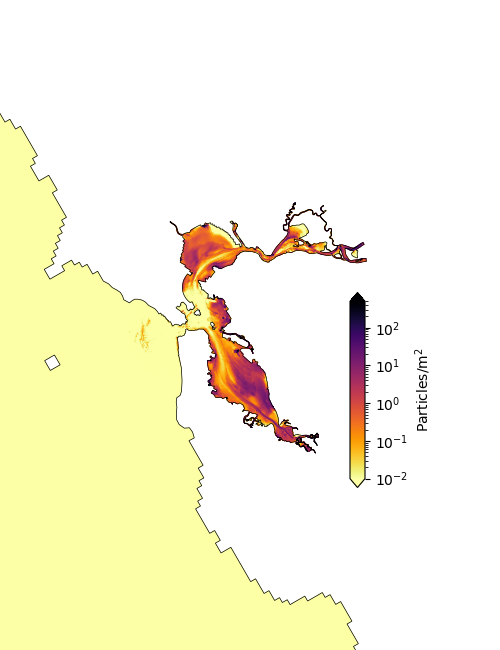

<IPython.core.display.Javascript object>


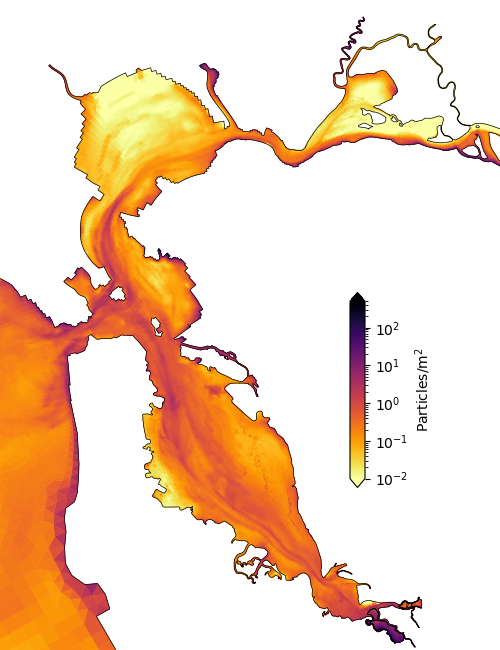

<IPython.core.display.Javascript object>


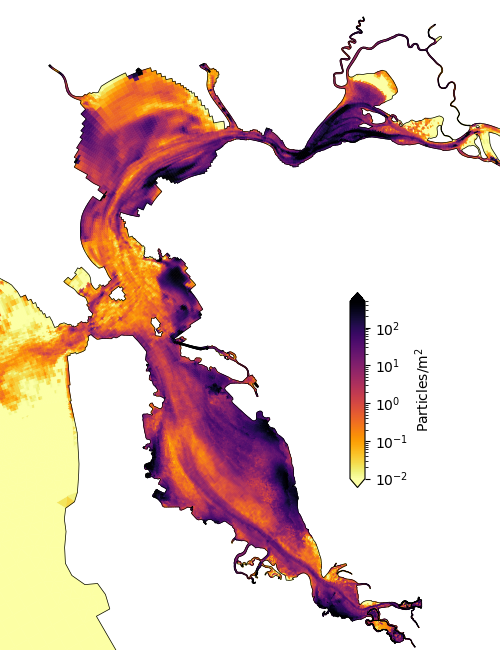

<IPython.core.display.Javascript object>


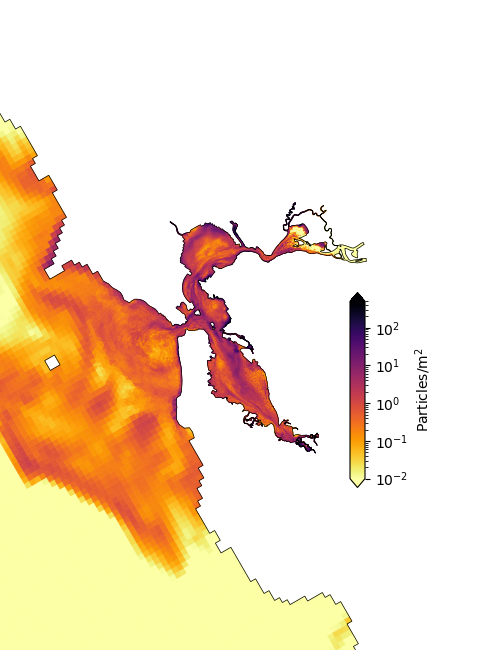

<IPython.core.display.Javascript object>


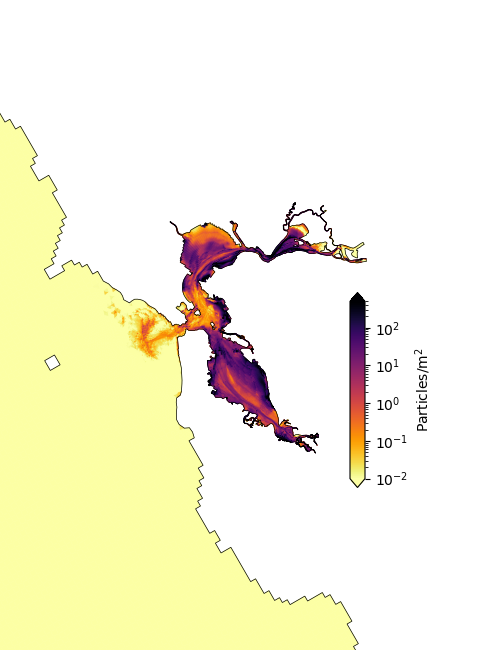

<IPython.core.display.Javascript object>


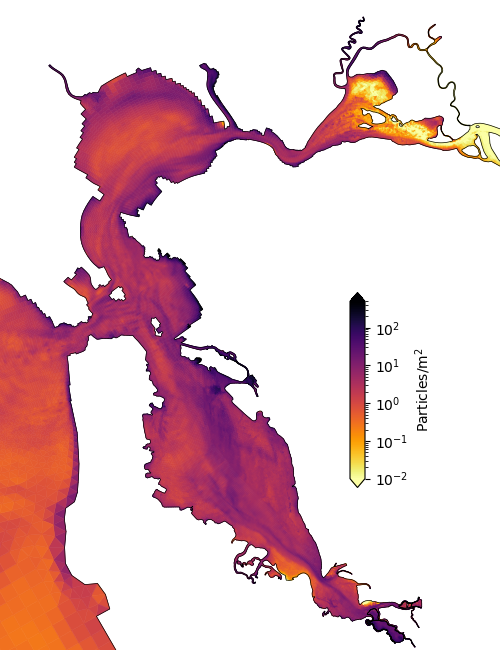

In [9]:
# likewise, a Bay-centric view for each, maybe less smoothing
# Show reach of particles over time:
out_dir="snapshots-v02"

conc_fns=glob.glob(os.path.join(out_dir,'*.nc'))
conc_fns.sort()

for conc_fn in conc_fns:
    fig_fn=conc_fn.replace('.nc','-bay-60days.png')
    #if os.path.exists(fig_fn): continue
    
    ds=xr.open_dataset(conc_fn)

    fig,ax=plt.subplots(1,1,figsize=(5,6.5))
    fig.subplots_adjust(left=0,right=1,top=1,bottom=0,wspace=0)
    fig.canvas.draw()

    age_max=60

    ds_sel=ds.sel(age_max=age_max).copy()
    # Smooth some...
    conc=ds_sel['conc'].values
    for _ in range(1):
        conc=Msmooth.dot(conc)
    ds_sel['conc']=('cell',),conc
    p=conc_figure.CoastalConcFigure(ds_sel,ax=ax,
                                    fig=fig,grid=grid,grid_poly=grid_poly,cmap=cmap)
    ax.texts=[]
    plt.setp(list(ax.spines.values()),visible=0)    
    ax.axis([533520., 603727., 4140683., 4231953.])
    p.cax.set_position([0.7,0.25,0.03,0.3])

    fig.savefig(fig_fn,dpi=200)
    ds.close()


<IPython.core.display.Javascript object>


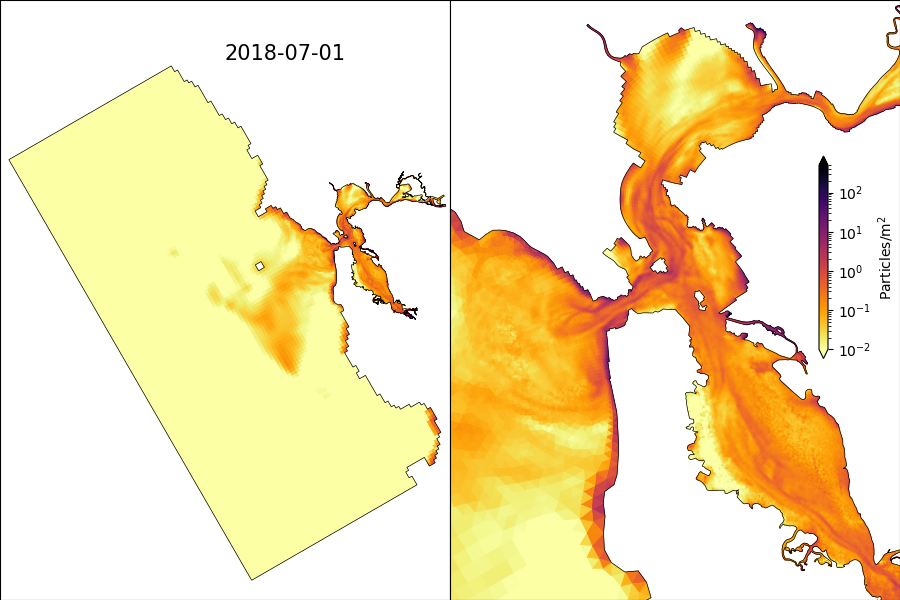

surface-frames-v05/frame-0391.png
surface-frames-v05/frame-0392.png
surface-frames-v05/frame-0393.png
surface-frames-v05/frame-0394.png
surface-frames-v05/frame-0395.png
surface-frames-v05/frame-0396.png
surface-frames-v05/frame-0397.png
surface-frames-v05/frame-0398.png
surface-frames-v05/frame-0399.png
surface-frames-v05/frame-0400.png
surface-frames-v05/frame-0401.png
surface-frames-v05/frame-0402.png
surface-frames-v05/frame-0403.png
surface-frames-v05/frame-0404.png
surface-frames-v05/frame-0405.png
surface-frames-v05/frame-0406.png
surface-frames-v05/frame-0407.png
surface-frames-v05/frame-0408.png
surface-frames-v05/frame-0409.png
surface-frames-v05/frame-0410.png
surface-frames-v05/frame-0411.png
surface-frames-v05/frame-0412.png
surface-frames-v05/frame-0413.png
surface-frames-v05/frame-0414.png
surface-frames-v05/frame-0415.png
surface-frames-v05/frame-0416.png
surface-frames-v05/frame-0417.png
surface-frames-v05/frame-0418.png
surface-frames-v05/frame-0419.png
surface-frames

surface-frames-v05/frame-0632.png
surface-frames-v05/frame-0633.png
surface-frames-v05/frame-0634.png
surface-frames-v05/frame-0635.png
surface-frames-v05/frame-0636.png
surface-frames-v05/frame-0637.png
surface-frames-v05/frame-0638.png
surface-frames-v05/frame-0639.png
surface-frames-v05/frame-0640.png
surface-frames-v05/frame-0641.png
surface-frames-v05/frame-0642.png
surface-frames-v05/frame-0643.png
surface-frames-v05/frame-0644.png
surface-frames-v05/frame-0645.png
surface-frames-v05/frame-0646.png
surface-frames-v05/frame-0647.png
surface-frames-v05/frame-0648.png
surface-frames-v05/frame-0649.png
surface-frames-v05/frame-0650.png
surface-frames-v05/frame-0651.png
surface-frames-v05/frame-0652.png
surface-frames-v05/frame-0653.png
surface-frames-v05/frame-0654.png
surface-frames-v05/frame-0655.png
surface-frames-v05/frame-0656.png
surface-frames-v05/frame-0657.png
surface-frames-v05/frame-0658.png
surface-frames-v05/frame-0659.png
surface-frames-v05/frame-0660.png
surface-frames

surface-frames-v05/frame-0873.png
surface-frames-v05/frame-0874.png
surface-frames-v05/frame-0875.png
surface-frames-v05/frame-0876.png
surface-frames-v05/frame-0877.png
surface-frames-v05/frame-0878.png
surface-frames-v05/frame-0879.png
surface-frames-v05/frame-0880.png
surface-frames-v05/frame-0881.png
surface-frames-v05/frame-0882.png
surface-frames-v05/frame-0883.png
surface-frames-v05/frame-0884.png
surface-frames-v05/frame-0885.png
surface-frames-v05/frame-0886.png
surface-frames-v05/frame-0887.png
surface-frames-v05/frame-0888.png
surface-frames-v05/frame-0889.png
surface-frames-v05/frame-0890.png
surface-frames-v05/frame-0891.png
surface-frames-v05/frame-0892.png
surface-frames-v05/frame-0893.png
surface-frames-v05/frame-0894.png
surface-frames-v05/frame-0895.png
surface-frames-v05/frame-0896.png
surface-frames-v05/frame-0897.png
surface-frames-v05/frame-0898.png
surface-frames-v05/frame-0899.png
surface-frames-v05/frame-0900.png
surface-frames-v05/frame-0901.png
surface-frames

In [22]:
fig,axs=plt.subplots(1,2,figsize=(9,6))

storm_factor=1.0
tau_d=30

# v03: regenerate with standardized colormap and
#  limited to 'valid' period of PTM output.
frame_dir="surface-frames-v05"
if not os.path.exists(frame_dir):
    os.makedirs(frame_dir)
    
win=post.godwin
win=win[win>0.0]
#len(win)

for i,ds_conc in enumerate(filter_stream(hourly_ncs,win,stride=8)):
    #if ds_conc.time.values > np.datetime64("2018-04-26"):
    #    print("Hit end of currently valid PTM output")
    #    break
    fig_fn=os.path.join(frame_dir,
                        f"frame-{i:04d}.png")
    if os.path.exists(fig_fn):
        continue
    print(fig_fn)
    
    ds_smooth=ds_conc.copy()
    # 2 iterations seems good for removing particle noise
    for _ in range(2):
        ds_smooth['conc']=('cell',), Msmooth.dot(ds_smooth.conc.values)

    fig.clf()
    axs=[fig.add_subplot(1,2,1),
         fig.add_subplot(1,2,2)]
    
    fig.subplots_adjust(left=0,right=1,top=1,bottom=0,wspace=0)

    kws=dict(grid=grid,grid_poly=grid_poly,fig=fig,cmap=cmap)             
    cf1=conc_figure.BayConcFigure(ds_smooth, ax=axs[1], 
                                  cax_loc=[0.82,0.37,0.02,0.45],
                                  **kws)
    cf2=conc_figure.CoastalConcFigure(ds_smooth,ax=axs[0],
                                      cax_loc=None,
                                      **kws)
    for ax in axs:
        ax.texts=[]

    date_s=utils.to_datetime(ds_conc.time.values).strftime("%Y-%m-%d")
    axs[0].text(0.5,0.9,date_s,transform=axs[0].transAxes,fontsize=15)
    # axs[0].axis([441742., 591985., 4076042., 4276366.])
    axs[0].axis([343651., 612368., 3973637., 4331926])
    axs[1].axis([522130., 582108., 4146136, 4226106.])
    #plt.draw()
    fig.savefig(fig_fn,dpi=120)
    #plt.pause(0.01)


In [11]:
from scipy.interpolate import interp1d

def interp_stream(ncs,stride=0.5):
    dss=[xr.open_dataset(fn) for fn in ncs]

    conc=np.array( [ds.conc.values for ds in dss])
    conc.shape # 300, 57124

    t_orig=np.arange(conc.shape[0])
    t_target=np.arange(t_orig[0],t_orig[-1],stride)
    conc_interp=interp1d(t_orig,conc,axis=0,kind='cubic')(t_target).clip(1e-4)
    
    t_values=np.array( [utils.to_unix(ds.time.values) for ds in dss])
    t_interp=utils.unix_to_dt64(np.interp(t_target, t_orig,t_values))
    
    ds0=dss[0].copy()
    [ds.close() for ds in dss]
    for t,data in zip(t_interp,conc_interp):
        ds0['conc']=('cell',),data
        ds0['time']=(),t
        yield ds0

In [26]:
hourly_ncs[5000:5200]

['hourly-out-v03/surface-20180306T0900.nc',
 'hourly-out-v03/surface-20180306T1000.nc',
 'hourly-out-v03/surface-20180306T1100.nc',
 'hourly-out-v03/surface-20180306T1200.nc',
 'hourly-out-v03/surface-20180306T1300.nc',
 'hourly-out-v03/surface-20180306T1400.nc',
 'hourly-out-v03/surface-20180306T1500.nc',
 'hourly-out-v03/surface-20180306T1600.nc',
 'hourly-out-v03/surface-20180306T1700.nc',
 'hourly-out-v03/surface-20180306T1800.nc',
 'hourly-out-v03/surface-20180306T1900.nc',
 'hourly-out-v03/surface-20180306T2000.nc',
 'hourly-out-v03/surface-20180306T2100.nc',
 'hourly-out-v03/surface-20180306T2200.nc',
 'hourly-out-v03/surface-20180307T0000.nc',
 'hourly-out-v03/surface-20180307T0100.nc',
 'hourly-out-v03/surface-20180307T0200.nc',
 'hourly-out-v03/surface-20180307T0300.nc',
 'hourly-out-v03/surface-20180307T0400.nc',
 'hourly-out-v03/surface-20180307T0500.nc',
 'hourly-out-v03/surface-20180307T0600.nc',
 'hourly-out-v03/surface-20180307T0700.nc',
 'hourly-out-v03/surface-2018030

<IPython.core.display.Javascript object>


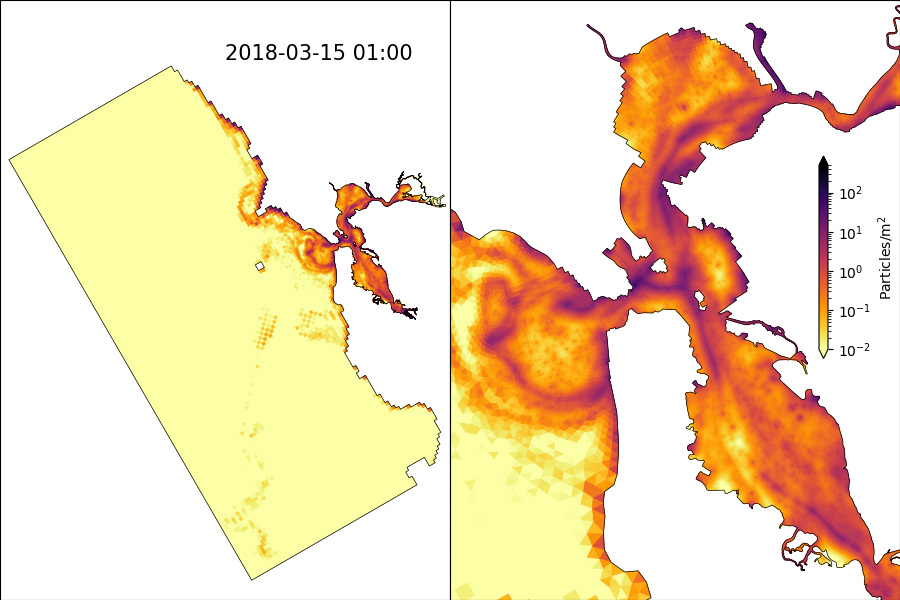

surface-tidal-frames-v07/frame-0000.png
surface-tidal-frames-v07/frame-0001.png
surface-tidal-frames-v07/frame-0002.png
surface-tidal-frames-v07/frame-0003.png
surface-tidal-frames-v07/frame-0004.png
surface-tidal-frames-v07/frame-0005.png
surface-tidal-frames-v07/frame-0006.png
surface-tidal-frames-v07/frame-0007.png
surface-tidal-frames-v07/frame-0008.png
surface-tidal-frames-v07/frame-0009.png
surface-tidal-frames-v07/frame-0010.png
surface-tidal-frames-v07/frame-0011.png
surface-tidal-frames-v07/frame-0012.png
surface-tidal-frames-v07/frame-0013.png
surface-tidal-frames-v07/frame-0014.png
surface-tidal-frames-v07/frame-0015.png
surface-tidal-frames-v07/frame-0016.png
surface-tidal-frames-v07/frame-0017.png
surface-tidal-frames-v07/frame-0018.png
surface-tidal-frames-v07/frame-0019.png
surface-tidal-frames-v07/frame-0020.png
surface-tidal-frames-v07/frame-0021.png
surface-tidal-frames-v07/frame-0022.png
surface-tidal-frames-v07/frame-0023.png
surface-tidal-frames-v07/frame-0024.png


In [27]:
# v03: regenerate with standardized colormap and
#  limited to 'valid' period of PTM output.
# v05: tidal time scales
# v07: wet season
fig,axs=plt.subplots(1,2,figsize=(9,6))

from scipy import sparse
frame_dir="surface-tidal-frames-v07"
if not os.path.exists(frame_dir):
    os.makedirs(frame_dir)
    
storm_factor=1.0
tau_d=30

# For stride<1, window length just means how
# many frames to keep in memory at a time.
#for i,ds_conc in enumerate(interp_stream(hourly_ncs[:200],stride=0.25)):
for i,ds_conc in enumerate(filter_stream(hourly_ncs[5000:5200],win=[1],stride=1)):
    fig_fn=os.path.join(frame_dir,
                        f"frame-{i:04d}.png")
    if os.path.exists(fig_fn):
        continue
    print(fig_fn)
    
    ds_smooth=ds_conc.copy()
    smooth=-10000
    M=Msmooth_K
    # 2 iterations seems good for removing particle noise
    # For tidal, single-hour data, need more smoothing.
    if smooth>0:
        for _ in range(smooth):
            ds_smooth['conc']=('cell',), M.dot(ds_smooth.conc.values)
    if smooth<0:                                                                                                                                            
        I=sparse.eye(*M.shape)                                                                                                                                
        M_imp=I-(M-I)*(-smooth)                                                                                                                         
        ds_smooth['conc']=('cell',),sparse.linalg.spsolve(M_imp,ds_smooth.conc.values)
    
    fig.clf()
    axs=[fig.add_subplot(1,2,1),
         fig.add_subplot(1,2,2)]
    
    fig.subplots_adjust(left=0,right=1,top=1,bottom=0,wspace=0)

    kws=dict(grid=grid,grid_poly=grid_poly,fig=fig,cmap=cmap)             
    cf1=conc_figure.BayConcFigure(ds_smooth, ax=axs[1], 
                                  cax_loc=[0.82,0.37,0.02,0.45],
                                  **kws)
    cf2=conc_figure.CoastalConcFigure(ds_smooth,ax=axs[0],
                                      cax_loc=None,
                                      **kws)
    for ax in axs:
        ax.texts=[]

    date_s=utils.to_datetime(ds_conc.time.values).strftime("%Y-%m-%d %H:%M")
    axs[0].text(0.5,0.9,date_s,transform=axs[0].transAxes,fontsize=15)
    #axs[0].axis([441742., 591985., 4076042., 4276366.])
    axs[0].axis([343651., 612368., 3973637., 4331926])
    axs[1].axis([522130., 582108., 4146136, 4226106.])
    #plt.draw()
    fig.savefig(fig_fn,dpi=120)
    #plt.pause(0.01)